In [1]:
###############################################################################
######################   UsedCarPrices_CarGurus  ##############################
######################  Regression - Nonlinear   ##############################
######################        MLP Methods        ##############################
###############################################################################

In [2]:
# Install and import packages
!pip install eli5
!pip install shap
from tensorflow import keras
import os
import random
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import datetime
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib as plt
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
import shap 

print('\n')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



TensorFlow version: 2.8.0
Eager execution is: True
Keras version: 2.8.0
Num GPUs Available:  1


In [3]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [4]:
init_seeds(seed=42)

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [7]:
df = pd.read_csv('usedCars_final.csv', low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (327912, 28)


In [8]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [9]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify=X.listed_date_yearMonth,
                                                    random_state = 42)

In [10]:
# Drop year variable
X_train = X_train.drop(['listed_date_yearMonth'], axis=1)
X_test = X_test.drop(['listed_date_yearMonth'], axis=1)

In [11]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Test: Create dummy variables for categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)

In [12]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train))
X_test = pd.DataFrame(mn.fit_transform(X_test))

In [13]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/MLP/Results/Models/

/content/drive/MyDrive/UsedCarsCarGurus/ML/MLP/Results/Models


In [14]:
!rm -rf /logs/

%load_ext tensorboard

log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [15]:
# Set up callbacks
filepath = 'MLP_weights_only_b1_HPO8patience15_stratifyYearMonth_bestModel.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience = 15),
                  ModelCheckpoint(filepath, monitor='mse', 
                                  save_best_only = True, mode='min'), 
                  tensorboard_callback]


In [16]:
# Define model
model = Sequential()
model.add(Dense(100, input_dim=50, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(60, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(95, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 60)                6060      
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 95)                2

In [17]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=1,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
209863/209863 [==============================] - 588s 3ms/step - loss: 4543.5332 - mse: 35979008.0000 - val_loss: 3165.0215 - val_mse: 17358874.0000
Epoch 2/50
209863/209863 [==============================] - 582s 3ms/step - loss: 4088.0383 - mse: 28834598.0000 - val_loss: 3019.9172 - val_mse: 15974792.0000
Epoch 3/50
209863/209863 [==============================] - 577s 3ms/step - loss: 3955.4636 - mse: 27010054.0000 - val_loss: 3138.9502 - val_mse: 17199764.0000
Epoch 4/50
209863/209863 [==============================] - 577s 3ms/step - loss: 3862.9250 - mse: 25755464.0000 - val_loss: 2860.9187 - val_mse: 14224336.0000
Epoch 5/50
209863/209863 [==============================] - 576s 3ms/step - loss: 3818.2244 - mse: 25117608.0000 - val_loss: 3023.4868 - val_mse: 16180316.0000
Epoch 6/50
209863/209863 [==============================] - 577s 3ms/step - loss: 3782.3472 - mse: 24746100.0000 - val_loss: 2832.3240 - val_mse: 14176007.0000
Epoch 7/50
209863/209863 [==============

In [18]:
# Save model
model.save('./220329_MLP_batch1_50epochs_HPO8patience15_stratifyYearMonth_bestModel_tf.h5', save_format='tf')

# Load model for more training or later use
#model = tf.keras.models.load_model('./220329_MLP_batch1_50epochs_HPO8patience15_stratifyYearMonth_bestModel_tf.h5')

# Show the model architecture
#model.summary()

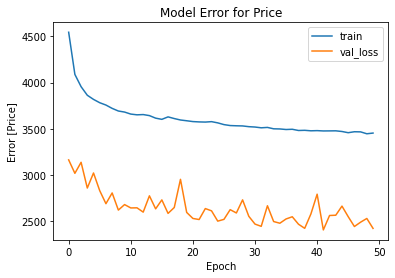

In [19]:
# Plot loss over epochs
my_dpi = 96
pyplot.title('Model Error for Price')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.ylabel('Error [Price]')
pyplot.xlabel('Epoch')
pyplot.legend()
pyplot.savefig('MLP_batch1_50epochs_wHPO8patience15model_stratifyYearMonth_Loss.png', dpi=my_dpi * 10,
               bbox_inches='tight')
pyplot.show()

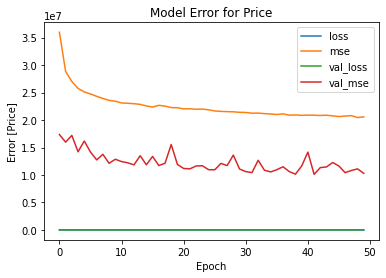

In [20]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
pyplot.title('Model Error for Price')
pyplot.ylabel('Error [Price]')
pyplot.xlabel('Epoch')
pyplot.legend(loc='upper right')
pyplot.savefig('MLP_batch1_50epochs_wHPO8patience15model_stratifyYearMonth_LossValLoss.png', dpi=my_dpi * 10,
               bbox_inches='tight')

In [21]:
# Predict on train set
pred_train = model.predict(X_train)

In [22]:
# Convert predicted shape to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(262329, 1)

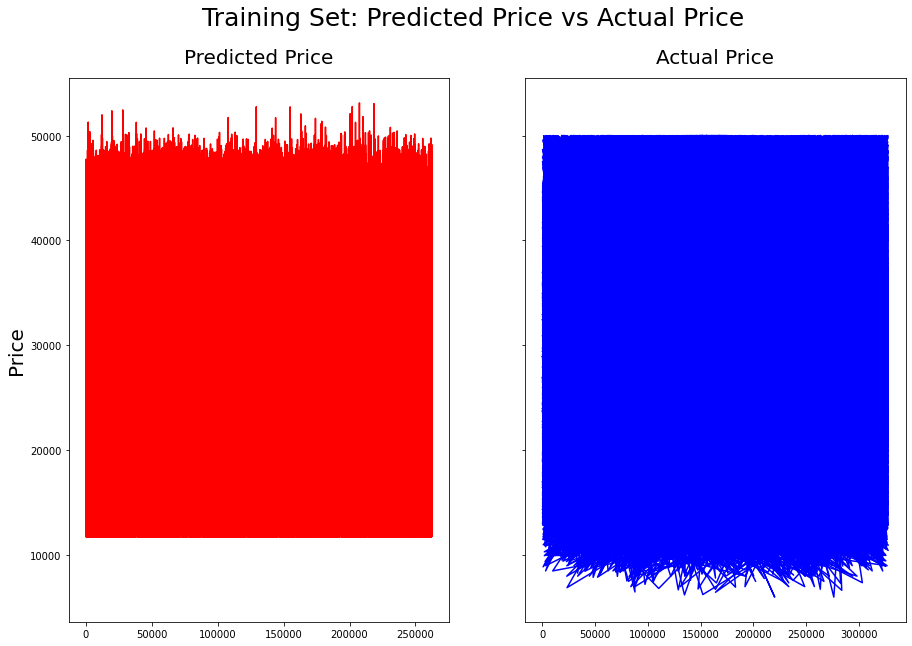

In [23]:
# Graph predicted vs actual price in the train set 
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.pyplot.subplots(1, 2, figsize=(15, 10), sharey=True)
f.suptitle('Training Set: Predicted Price vs Actual Price',
           fontsize = 25)
ax1.plot(y_pred, color = 'red')
ax1.set_title('Predicted Price', pad = 15, fontsize = 20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_train, color = 'blue')
ax2.set_title('Actual Price', pad = 15, fontsize = 20)
pyplot.show()

In [24]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('MLP_batch1_50epochs_wHPO8patience15model_stratifyYearMonth_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

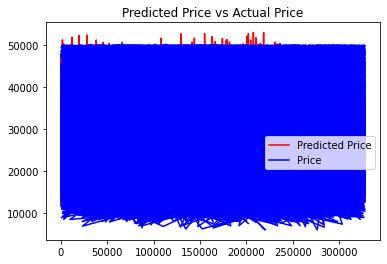

In [25]:
# Graph overlaid predicted vs actual price in the train set 
plt.rcParams['agg.path.chunksize'] = 1000
pyplot.title('Predicted Price vs Actual Price')
pyplot.plot(y_pred, color = 'red', label = 'Predicted Price')
pyplot.plot(y_train, color = 'blue', label = 'Price')
pyplot.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
pyplot.savefig('MLP_batch1_50epochs_wHPO8patience15model_stratifyYearMonth_PredictedActual_Train_Overlaid.png',
               dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [26]:
# Predict on test set
pred_test = model.predict(X_test)

In [27]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)

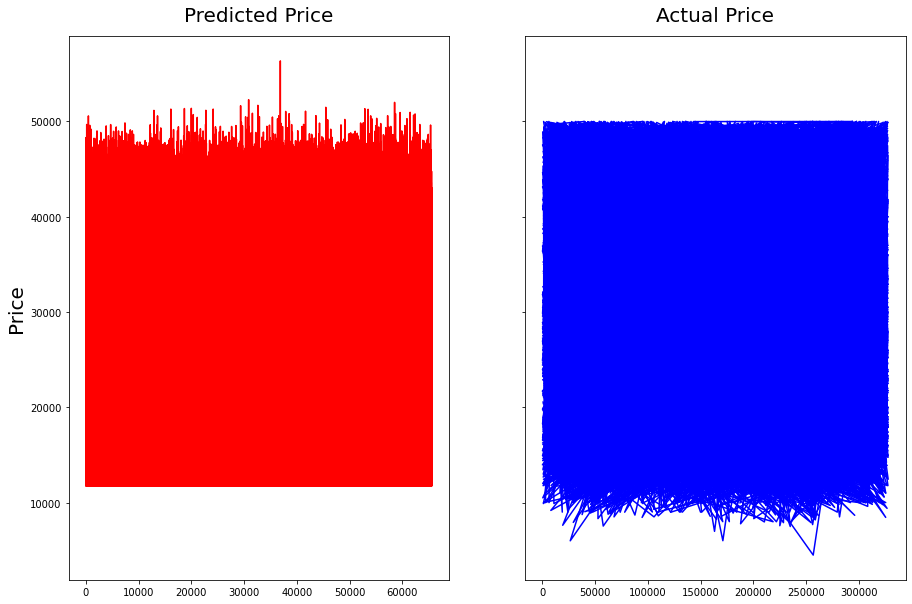

In [28]:
# Graph predicted vs actual price in the test set 
plt.rcParams['agg.path.chunksize'] = 1000
f, ((ax1), (ax2)) = plt.pyplot.subplots(1, 2, figsize=(15, 10), sharey=True)
ax1.plot(y_pred, color = 'red')
ax1.set_title('Predicted Price', pad = 15, fontsize = 20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_test, color = 'blue')
ax2.set_title('Actual Price', pad = 15, fontsize = 20)
pyplot.show()

In [29]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('MLP_batch1_50epochs_wHPO8patience15model_stratifyYearMonth_PredictedActual_Test_Side.png',
          dpi=my_dpi, bbox_inches='tight')

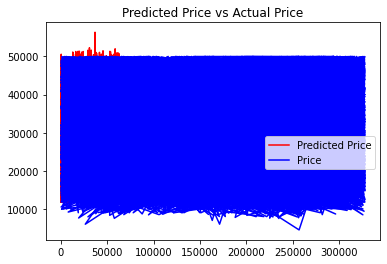

In [30]:
# Graph overlaid predicted vs actual price in the test set 
plt.rcParams['agg.path.chunksize'] = 1000
pyplot.title('Predicted Price vs Actual Price')
pyplot.plot(y_pred, color = 'red', label = 'Predicted Price')
pyplot.plot(y_test, color = 'blue', label = 'Price')
pyplot.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
pyplot.savefig('MLP_batch1_50epochs_wHPO8patience15model_stratifyYearMonth_PredictedActual_Test_Overlaid.png',
               dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [31]:
# Metrics from training model 
print('Train Mean Absolute Error (MAE):', mean_absolute_error(y_train[:], pred_train[:]))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(y_train[:], pred_train[:]))
print('Train Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_train[:], pred_train[:])))

Train Mean Absolute Error (MAE): 2418.31560742903
Mean Square Error (MSE): 10209240.376097
Train Root Mean Squared Error (RMSE): 3195.1901940411185


In [32]:
# Metrics from test set 
print('Test Mean Absolute Error (MAE):', mean_absolute_error(y_test[:], pred_test[:]))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(y_test[:], pred_test[:]))
print('Test Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test[:], pred_test[:])))

Test Mean Absolute Error (MAE): 3532.3940749734593
Mean Square Error (MSE): 21571630.997167
Test Root Mean Squared Error (RMSE): 4644.526993910902


In [33]:
# Predicted maximum, average and minimum price
print("Predicted Max Price")
print(np.amax(pred_test))
("\n")
print("Predicted Average Price")
print(np.average(pred_test))
("\n")
print("Predicted Minimum Price")
print(np.amin(pred_test))

Predicted Max Price
56349.258
Predicted Average Price
26449.344
Predicted Minimum Price
11753.381


In [34]:
# Maxmimum, average and minimum real price
print("Maximum Price")
print(np.amax(y_test))
("\n")
print("Average Price")
print(np.average(y_test))
("\n")
print("Minimum Price")
print(np.amin(y_test))

Maximum Price
50000.0
Average Price
28235.49633045149
Minimum Price
4490.0
